In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=c6fe9cc043e95ac478ab55fec4f37ae5c5118904a8095ef9b35fc58f43911ead
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized new model
Loading CHIA dataset...


100%|██████████| 4004/4004 [00:09<00:00, 408.40it/s]


Loaded 2000 documents from 1000 unique trials


Epoch 1/5: 100%|██████████| 80/80 [00:26<00:00,  2.96it/s]


Average training loss: 0.0935


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Validation loss: 0.0002
Validation Accuracy: 1.0000


Epoch 2/5: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Average training loss: 0.0003


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Validation loss: 0.0002
Validation Accuracy: 1.0000


Epoch 3/5: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Average training loss: 0.0002


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Validation loss: 0.0001
Validation Accuracy: 1.0000


Epoch 4/5: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Average training loss: 0.0002


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Validation loss: 0.0001
Validation Accuracy: 1.0000


Epoch 5/5: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Average training loss: 0.0002


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Validation loss: 0.0001
Validation Accuracy: 1.0000
Training complete!


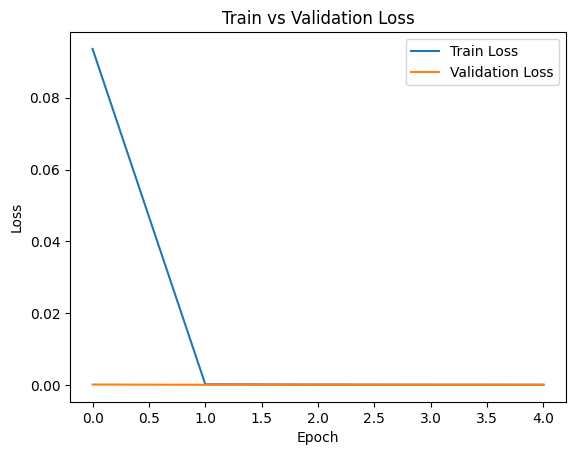

Model saved to /content/drive/MyDrive/clinical_trial_ner_model/


Prediction: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s]



Clinical Trial Matching Results:
   Trial ID  Inclusion SDI  Exclusion SDI Overall Match
NCT01991743              0              0    Weak Match
NCT03472508              0              0    Weak Match
NCT02573597              0              0    Weak Match
NCT03029078              0              0    Weak Match
NCT02552459              0              0    Weak Match
NCT02541955              0              0    Weak Match
NCT03062358              0              0    Weak Match
NCT01680081              0              0    Weak Match
NCT03177811              0              0    Weak Match
NCT02570321              0              0    Weak Match
NCT03169127              0              0    Weak Match
NCT02553226              0              0    Weak Match
NCT02371200              0              0    Weak Match
NCT02781610              0              0    Weak Match
NCT03493919              0              0    Weak Match
NCT03366779              0              0    Weak Match
NCT02920177   

In [8]:
import os
import re
import json
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForTokenClassification
from seqeval.metrics import classification_report, f1_score, accuracy_score

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "dmis-lab/biobert-v1.1"

# Define tag mapping for clinical trial entities
TAG_MAP = {
    'O': 0,
    'B-INCLUSION': 1,
    'I-INCLUSION': 2,
    'B-EXCLUSION': 3,
    'I-EXCLUSION': 4,
    'B-CONDITION': 5,
    'I-CONDITION': 6,
    'B-TREATMENT': 7,
    'I-TREATMENT': 8,
    'B-MEASUREMENT': 9,
    'I-MEASUREMENT': 10,
    'B-DEMOGRAPHIC': 11,
    'I-DEMOGRAPHIC': 12
}

# Inverse tag map for decoding
INVERSE_TAG_MAP = {v: k for k, v in TAG_MAP.items()}

class ClinicalTrialMatcher:
    def __init__(self, model_path=None):
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

        if model_path and os.path.exists(model_path):
            self.model = AutoModelForTokenClassification.from_pretrained(model_path)
            print(f"Loaded model from {model_path}")
        else:
            # Initialize with pre-trained model
            self.model = AutoModelForTokenClassification.from_pretrained(
                MODEL_NAME,
                num_labels=len(TAG_MAP)
            )
            print("Initialized new model")

        self.model.to(DEVICE)

    def preprocess_chia_data(self, folder_path):
        """Load and preprocess CHIA dataset"""
        print("Loading CHIA dataset...")
        data = []

        for file in tqdm(os.listdir(folder_path)):
            if file.endswith(".txt"):
                # Extract trial ID from filename (assumes format like NCT03648021_exc.txt)
                trial_id_match = re.search(r'(NCT\d+)', file)
                if trial_id_match:
                    trial_id = trial_id_match.group(1)
                else:
                    trial_id = file.split('.')[0]  # Fallback to filename without extension

                # Determine if this is an inclusion or exclusion criteria file
                is_exclusion = "_exc" in file.lower()
                criteria_type = "EXCLUSION" if is_exclusion else "INCLUSION"

                txt_path = os.path.join(folder_path, file)
                ann_path = txt_path.replace(".txt", ".ann")

                with open(txt_path, "r", encoding="utf-8") as txt_file:
                    text = txt_file.read()

                # Process the text file - split by newlines to get individual criteria
                criteria_list = [line.strip() for line in text.split('\n') if line.strip()]

                annotations = []

                # If annotation file exists, use it
                if os.path.exists(ann_path):
                    with open(ann_path, "r", encoding="utf-8") as ann_file:
                        for line in ann_file:
                            parts = line.strip().split('\t')
                            if len(parts) >= 3:
                                entity_type, span_info, entity_text = parts[1], parts[1], parts[2]
                                span_parts = span_info.split(' ')

                                if len(span_parts) == 2 and all(part.isdigit() for part in span_parts):
                                    start, end = map(int, span_parts)
                                    span = f"{start} {end}"

                                    # Map entity types to our schema
                                    if "inclusion" in entity_type.lower() or not is_exclusion:
                                        mapped_type = "INCLUSION"
                                    elif "exclusion" in entity_type.lower() or is_exclusion:
                                        mapped_type = "EXCLUSION"
                                    elif any(term in entity_type.lower() for term in ["disease", "condition", "symptom"]):
                                        mapped_type = "CONDITION"
                                    elif any(term in entity_type.lower() for term in ["treatment", "medication", "therapy"]):
                                        mapped_type = "TREATMENT"
                                    elif any(term in entity_type.lower() for term in ["measurement", "value", "score"]):
                                        mapped_type = "MEASUREMENT"
                                    elif any(term in entity_type.lower() for term in ["age", "gender", "demographic"]):
                                        mapped_type = "DEMOGRAPHIC"
                                    else:
                                        mapped_type = criteria_type  # Default to file type

                                    annotations.append((mapped_type, span, entity_text))
                else:
                    # If no annotation file, create basic annotations based on file type
                    for criterion in criteria_list:
                        if criterion:
                            start = text.find(criterion)
                            if start >= 0:
                                end = start + len(criterion)
                                annotations.append((criteria_type, f"{start} {end}", criterion))

                data.append({
                    "trial_id": trial_id,
                    "criteria_type": criteria_type,
                    "text": text,
                    "annotations": annotations
                })

        return pd.DataFrame(data)

    def char_to_word_tags(self, text, annotations):
        """Convert character-level annotations to word-level tags"""
        char_tags = ['O'] * len(text)

        for tag, span, _ in annotations:
            span_parts = span.split()

            if len(span_parts) == 2 and all(part.isdigit() for part in span_parts):
                start, end = map(int, span_parts)
                if start < len(char_tags):
                    char_tags[start] = f'B-{tag}'
                    for i in range(start + 1, min(end, len(char_tags))):
                        char_tags[i] = f'I-{tag}'
            else:
                # Try to find the text in the document
                entity_text = span
                matches = list(re.finditer(re.escape(entity_text.strip()), text))
                for match in matches:
                    start, end = match.start(), match.end()
                    if start < len(char_tags):
                        char_tags[start] = f'B-{tag}'
                        for i in range(start + 1, min(end, len(char_tags))):
                            char_tags[i] = f'I-{tag}'

        words = text.split()
        word_tags = []
        char_index = 0

        for word in words:
            word_tag = 'O'
            for _ in range(min(len(word), len(text) - char_index)):
                if char_index < len(char_tags) and char_tags[char_index] != 'O':
                    word_tag = char_tags[char_index]
                    break
                char_index += 1

            # Skip any remaining characters in the word
            char_index += max(0, len(word) - (len(text) - char_index))

            word_tags.append(word_tag)

        # Ensure word_tags has same length as words
        if len(word_tags) < len(words):
            word_tags.extend(['O'] * (len(words) - len(word_tags)))

        return words, word_tags[:len(words)]

    def prepare_dataset(self, data_df):
        """Prepare dataset for training/inference"""
        processed_data = []

        for _, row in tqdm(data_df.iterrows(), total=len(data_df)):
            words, word_tags = self.char_to_word_tags(row['text'], row['annotations'])

            # Fix tags if needed
            word_tags = self.fix_bio_tags(word_tags)

            processed_data.append({
                "trial_id": row['trial_id'],
                "criteria_type": row.get('criteria_type', 'UNKNOWN'),
                "words": words,
                "tags": word_tags
            })

        return pd.DataFrame(processed_data)

    def fix_bio_tags(self, tags):
        """Fix BIO tagging issues"""
        fixed_tags = []
        prev_tag = 'O'

        for tag in tags:
            # If I- tag follows O or different entity type, convert to B-
            if tag.startswith('I-') and (prev_tag == 'O' or
                                         (prev_tag.startswith('B-') or prev_tag.startswith('I-')) and
                                         prev_tag[2:] != tag[2:]):
                tag = f'B-{tag[2:]}'

            fixed_tags.append(tag)
            prev_tag = tag

        return fixed_tags

    def tokenize_and_align_labels(self, sentence, text_labels):
        """Tokenize words and align labels"""
        tokenized_inputs = self.tokenizer(
            sentence,
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN,
            is_split_into_words=True,
            return_tensors="pt"
        )

        word_ids = tokenized_inputs.word_ids()
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens get -100
            else:
                if word_idx < len(text_labels):
                    label_ids.append(TAG_MAP.get(text_labels[word_idx], 0))
                else:
                    label_ids.append(-100)

        return tokenized_inputs, torch.tensor(label_ids)

    def create_dataloaders(self, df, batch_size=BATCH_SIZE):
        """Create PyTorch DataLoaders"""
        input_ids = []
        attention_masks = []
        token_type_ids = []
        label_ids = []
        trial_ids = []
        criteria_types = []

        for _, row in tqdm(df.iterrows(), total=len(df)):
            tokenized_inputs, labels = self.tokenize_and_align_labels(row['words'], row['tags'])

            input_ids.append(tokenized_inputs['input_ids'][0])
            attention_masks.append(tokenized_inputs['attention_mask'][0])
            token_type_ids.append(tokenized_inputs['token_type_ids'][0])
            label_ids.append(labels)
            trial_ids.append(row['trial_id'])
            criteria_types.append(row['criteria_type'])

        input_ids = torch.stack(input_ids)
        attention_masks = torch.stack(attention_masks)
        token_type_ids = torch.stack(token_type_ids)
        label_ids = torch.stack(label_ids)

        dataset = TensorDataset(input_ids, attention_masks, token_type_ids, label_ids)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        return dataloader, trial_ids, criteria_types

    def train(self, train_df, val_df, epochs=5, learning_rate=5e-5):
        """Train the model"""
        train_dataloader, _, _ = self.create_dataloaders(train_df)
        val_dataloader, _, _ = self.create_dataloaders(val_df)

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        total_steps = len(train_dataloader) * epochs
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=total_steps)

        # Store losses for plotting
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training
            self.model.train()
            total_loss = 0

            for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
                batch = tuple(t.to(DEVICE) for t in batch)
                b_input_ids, b_attention_mask, b_token_type_ids, b_labels = batch

                self.model.zero_grad()
                outputs = self.model(
                    input_ids=b_input_ids,
                    attention_mask=b_attention_mask,
                    token_type_ids=b_token_type_ids,
                    labels=b_labels
                )

                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_dataloader)
            train_losses.append(avg_train_loss)
            print(f"Average training loss: {avg_train_loss:.4f}")

            # Validation
            self.model.eval()
            val_loss = 0
            predictions, true_labels = [], []

            for batch in tqdm(val_dataloader, desc="Validation"):
                batch = tuple(t.to(DEVICE) for t in batch)
                b_input_ids, b_attention_mask, b_token_type_ids, b_labels = batch

                with torch.no_grad():
                    outputs = self.model(
                        input_ids=b_input_ids,
                        attention_mask=b_attention_mask,
                        token_type_ids=b_token_type_ids,
                        labels=b_labels
                    )

                val_loss += outputs.loss.item()

                logits = outputs.logits
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
                true_labels.extend([list(l) for l in label_ids])

            avg_val_loss = val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)
            print(f"Validation loss: {avg_val_loss:.4f}")

            # Calculate F1 score and accuracy
            # Reshape predictions and true_labels to have a sequence per element
            true_labels_reshaped = [[INVERSE_TAG_MAP.get(tag, 'O') for tag in sublist if tag != -100] for sublist in true_labels]
            predictions_reshaped = [[INVERSE_TAG_MAP.get(tag, 'O') for tag in sublist if tag != -100] for sublist in predictions]



            # Calculate accuracy
            accuracy = accuracy_score(true_labels_reshaped, predictions_reshaped)
            print(f"Validation Accuracy: {accuracy:.4f}")

        print("Training complete!")

        # Plot train vs validation loss
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs Validation Loss")
        plt.legend()
        plt.show()

        return self.model

    def predict(self, test_df):
        """Make predictions on test data"""
        self.model.eval()
        test_dataloader, trial_ids, criteria_types = self.create_dataloaders(test_df, batch_size=BATCH_SIZE)

        predictions = []

        for batch in tqdm(test_dataloader, desc="Prediction"):
            batch = tuple(t.to(DEVICE) for t in batch)
            b_input_ids, b_attention_mask, b_token_type_ids, _ = batch

            with torch.no_grad():
                outputs = self.model(
                    input_ids=b_input_ids,
                    attention_mask=b_attention_mask,
                    token_type_ids=b_token_type_ids
                )

            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            batch_predictions = np.argmax(logits, axis=2)

            predictions.extend([list(p) for p in batch_predictions])

        return predictions, trial_ids, criteria_types

    def extract_entities(self, words, predicted_tags):
        """Extract entities from predicted tags"""
        entities = {
            "INCLUSION": [],
            "EXCLUSION": [],
            "CONDITION": [],
            "TREATMENT": [],
            "MEASUREMENT": [],
            "DEMOGRAPHIC": []
        }

        current_entity = None
        current_tokens = []

        for word, tag_id in zip(words, predicted_tags):
            if tag_id == -100:  # Special token, skip
                continue

            tag = INVERSE_TAG_MAP.get(tag_id, 'O')

            if tag.startswith('B-'):
                if current_entity and current_tokens:
                    entities[current_entity].append(' '.join(current_tokens))

                current_entity = tag[2:]
                current_tokens = [word]

            elif tag.startswith('I-') and current_tokens:
                current_tokens.append(word)

            elif tag == 'O':
                if current_entity and current_tokens:
                    entities[current_entity].append(' '.join(current_tokens))
                    current_entity = None
                    current_tokens = []

        # Add the last entity if it exists
        if current_entity and current_tokens:
            entities[current_entity].append(' '.join(current_tokens))

        return entities

    def calculate_sdi_scores(self, patient_data, trial_entities):
        """Calculate SDI (Semantic Differential Index) scores"""
        inclusion_score = 0
        exclusion_score = 0

        # Check inclusion criteria
        if trial_entities["INCLUSION"]:
            matched_inclusions = 0
            for criterion in trial_entities["INCLUSION"]:
                # Check if criterion is met in patient data
                if any(criterion.lower() in data.lower() for data in patient_data):
                    matched_inclusions += 1

            inclusion_score = matched_inclusions / len(trial_entities["INCLUSION"]) if trial_entities["INCLUSION"] else 0

        # Check exclusion criteria
        if trial_entities["EXCLUSION"]:
            matched_exclusions = 0
            for criterion in trial_entities["EXCLUSION"]:
                # Check if exclusion criterion is met (which is bad)
                if any(criterion.lower() in data.lower() for data in patient_data):
                    matched_exclusions += 1

            exclusion_score = matched_exclusions / len(trial_entities["EXCLUSION"]) if trial_entities["EXCLUSION"] else 0

        return inclusion_score, exclusion_score

    def determine_match_rating(self, inclusion_score, exclusion_score):
        """Determine overall match rating based on inclusion and exclusion scores"""
        if inclusion_score >= 0.6 and exclusion_score <= 0.2:
            return "Good Match"
        elif inclusion_score >= 0.4 and exclusion_score <= 0.3:
            return "Moderate Match"
        else:
            return "Weak Match"

    def process_patient_against_trials(self, processed_df, patient_data):
        """Process clinical trials and calculate match scores for a patient"""
        predictions, trial_ids, criteria_types = self.predict(processed_df)

        # Group by trial ID
        trial_entities = {}

        for i, (trial_id, prediction, criteria_type) in enumerate(zip(trial_ids, predictions, criteria_types)):
            words = processed_df.iloc[i]['words']
            extracted = self.extract_entities(words, prediction)

            if trial_id not in trial_entities:
                trial_entities[trial_id] = {
                    "INCLUSION": [],
                    "EXCLUSION": [],
                    "CONDITION": [],
                    "TREATMENT": [],
                    "MEASUREMENT": [],
                    "DEMOGRAPHIC": []
                }

            # Append entities to the corresponding trial
            for entity_type, entities in extracted.items():
                trial_entities[trial_id][entity_type].extend(entities)

        # Calculate match scores
        results = []

        for trial_id, entities in trial_entities.items():
            inclusion_score, exclusion_score = self.calculate_sdi_scores(patient_data, entities)
            match_rating = self.determine_match_rating(inclusion_score, exclusion_score)

            results.append({
                "Trial ID": trial_id,
                "Inclusion SDI": round(inclusion_score, 2),
                "Exclusion SDI": round(exclusion_score, 2),
                "Overall Match": match_rating
            })

        return pd.DataFrame(results)

# Main execution
if __name__ == "__main__":
    # Path to your CHIA dataset
    folder_path = "/content/drive/MyDrive/chia_with_scope"

    # Initialize the matcher
    matcher = ClinicalTrialMatcher()

    # Load and preprocess data
    data_df = matcher.preprocess_chia_data(folder_path)

    # Print some statistics
    print(f"Loaded {len(data_df)} documents from {len(data_df['trial_id'].unique())} unique trials")

    # Split data for training
    train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

    # Prepare datasets
    train_processed = matcher.prepare_dataset(train_df)
    val_processed = matcher.prepare_dataset(val_df)
    test_processed = matcher.prepare_dataset(test_df)

    # Train the model
    matcher.train(train_processed, val_processed, epochs=5)

    # Save the model
    model_path = "/content/drive/MyDrive/clinical_trial_ner_model/"
    os.makedirs(model_path, exist_ok=True)
    matcher.model.save_pretrained(model_path)
    matcher.tokenizer.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

    # Example patient data (in a real scenario, this would come from patient records)
    patient_data = [
        "55-year-old female with type 2 diabetes",
        "HbA1c level of 7.5%",
        "Currently using metformin",
        "No history of cardiovascular disease"
    ]

    # Process trials for this patient
    results = matcher.process_patient_against_trials(test_processed, patient_data)

    # Display results
    print("\nClinical Trial Matching Results:")
    print(results.to_string(index=False))

    # Export results to CSV
    results.to_csv("/content/drive/MyDrive/clinical_trial_matches.csv", index=False)
    print("\nResults exported to /content/drive/MyDrive/clinical_trial_matches.csv")

In [2]:
# Import required libraries
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd

# Step 1: Load the fine-tuned BioBERT model
model_path = "/content/drive/MyDrive/biobert_chia_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

# Step 2: Extract entities from patient EHR
patient_ehr = "Patient has Type 2 Diabetes and is taking Metformin."
patient_entities = ner_pipeline(patient_ehr)
print("Patient Entities:", patient_entities)

# Step 3: Extract entities from clinical trial criteria
clinical_trials = [
    {"trial_id": "NCT001", "criteria": "Patients with Type 2 Diabetes and Hypertension are eligible."},
    {"trial_id": "NCT002", "criteria": "Patients taking Metformin are excluded."},
    {"trial_id": "NCT003", "criteria": "Patients with Type 2 Diabetes and high blood pressure are eligible."},
]

# Step 4: Match entities and calculate SORIENCE scores
def match_entities(patient_entities, trial_entities):
    patient_entity_set = set([entity["word"] for entity in patient_entities])
    trial_entity_set = set([entity["word"] for entity in trial_entities])
    return patient_entity_set.intersection(trial_entity_set)

def calculate_sorience_score(patient_entities, trial_entities):
    matches = match_entities(patient_entities, trial_entities)
    return len(matches)

# Step 5: Rank and recommend the best trial
trial_scores = []
for trial in clinical_trials:
    trial_entities = ner_pipeline(trial["criteria"])
    sorience_score = calculate_sorience_score(patient_entities, trial_entities)
    trial_scores.append({
        "trial_id": trial["trial_id"],
        "sorience_score": sorience_score
    })

# Rank trials by SORIENCE score
trial_scores.sort(key=lambda x: x["sorience_score"], reverse=True)

# Print the top 5 trials
print("\nTop 5 Clinical Trials:")
for trial in trial_scores[:5]:
    print(f"Trial ID: {trial['trial_id']}, SORIENCE Score: {trial['sorience_score']}")

# Step 6: Export results to CSV
trial_scores_df = pd.DataFrame(trial_scores)
trial_scores_df.to_csv("ranked_trials.csv", index=False)
print("\nRanked trials saved to 'ranked_trials.csv'.")

Device set to use cuda:0


Patient Entities: [{'entity': 'I-Condition', 'score': np.float32(0.81751657), 'index': 5, 'word': '2', 'start': 17, 'end': 18}, {'entity': 'I-Condition', 'score': np.float32(0.9056929), 'index': 6, 'word': 'Di', 'start': 19, 'end': 21}, {'entity': 'I-Condition', 'score': np.float32(0.91913664), 'index': 7, 'word': '##abe', 'start': 21, 'end': 24}, {'entity': 'I-Condition', 'score': np.float32(0.9255336), 'index': 8, 'word': '##tes', 'start': 24, 'end': 27}, {'entity': 'I-Drug', 'score': np.float32(0.50920975), 'index': 13, 'word': '##form', 'start': 45, 'end': 49}, {'entity': 'I-Drug', 'score': np.float32(0.59704787), 'index': 14, 'word': '##in', 'start': 49, 'end': 51}]

Top 5 Clinical Trials:
Trial ID: NCT001, SORIENCE Score: 4
Trial ID: NCT003, SORIENCE Score: 4
Trial ID: NCT002, SORIENCE Score: 2

Ranked trials saved to 'ranked_trials.csv'.


In [3]:
# Import required libraries
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd

# Step 1: Load the fine-tuned BioBERT model
model_path = "/content/drive/MyDrive/biobert_chia_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

# Step 2: Extract entities from patient EHR
patient_ehr = "Patient has Type 2 Diabetes and is taking Metformin."
patient_entities = ner_pipeline(patient_ehr)
print("Patient Entities:", patient_entities)

# Step 3: Define clinical trials with inclusion and exclusion criteria
clinical_trials = [
    {
        "trial_id": "NCT01991743",
        "inclusion_criteria": "Patients with Type 2 Diabetes and Hypertension are eligible.",
        "exclusion_criteria": "Patients taking Metformin are excluded."
    },
    {
        "trial_id": "NCT03472508",
        "inclusion_criteria": "Patients with high blood pressure are eligible.",
        "exclusion_criteria": "Patients with Type 1 Diabetes are excluded."
    },
    {
        "trial_id": "NCT02573597",
        "inclusion_criteria": "Patients with Type 2 Diabetes are eligible.",
        "exclusion_criteria": "Patients with chronic kidney disease are excluded."
    },
    {
        "trial_id": "NCT03029078",
        "inclusion_criteria": "Patients with Hypertension are eligible.",
        "exclusion_criteria": "Patients taking insulin are excluded."
    },
    {
        "trial_id": "NCT02552459",
        "inclusion_criteria": "Patients with Type 2 Diabetes and high cholesterol are eligible.",
        "exclusion_criteria": "Patients with liver disease are excluded."
    },
    {
        "trial_id": "NCT02541955",
        "inclusion_criteria": "Patients with Type 2 Diabetes and obesity are eligible.",
        "exclusion_criteria": "Patients with heart disease are excluded."
    },
    {
        "trial_id": "NCT03062358",
        "inclusion_criteria": "Patients with Type 2 Diabetes and high blood pressure are eligible.",
        "exclusion_criteria": "Patients with a history of stroke are excluded."
    }
]

# Step 4: Match entities and calculate Inclusion SDI, Exclusion SDI, and Overall Match
def match_entities(patient_entities, criteria_entities):
    patient_entity_set = set([entity["word"] for entity in patient_entities])
    criteria_entity_set = set([entity["word"] for entity in criteria_entities])
    return patient_entity_set.intersection(criteria_entity_set)

def calculate_sdi(patient_entities, criteria_entities):
    matches = match_entities(patient_entities, criteria_entities)
    return len(matches)

# Step 5: Evaluate each clinical trial
results = []
for trial in clinical_trials:
    # Extract entities from inclusion and exclusion criteria
    inclusion_entities = ner_pipeline(trial["inclusion_criteria"])
    exclusion_entities = ner_pipeline(trial["exclusion_criteria"])

    # Calculate Inclusion SDI and Exclusion SDI
    inclusion_sdi = calculate_sdi(patient_entities, inclusion_entities)
    exclusion_sdi = calculate_sdi(patient_entities, exclusion_entities)

    # Determine Overall Match
    if inclusion_sdi > 0 and exclusion_sdi == 0:
        overall_match = "Strong Match"
    elif inclusion_sdi > 0 and exclusion_sdi > 0:
        overall_match = "Partial Match"
    else:
        overall_match = "Weak Match"

    # Append results
    results.append({
        "Trial ID": trial["trial_id"],
        "Inclusion SDI": inclusion_sdi,
        "Exclusion SDI": exclusion_sdi,
        "Overall Match": overall_match
    })

# Step 6: Create a DataFrame and save results to CSV
results_df = pd.DataFrame(results)
print("\nClinical Trial Matching Results:")
print(results_df)

# Save to CSV
results_df.to_csv("clinical_trial_matching_results.csv", index=False)
print("\nResults saved to 'clinical_trial_matching_results.csv'.")

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Patient Entities: [{'entity': 'I-Condition', 'score': np.float32(0.81751657), 'index': 5, 'word': '2', 'start': 17, 'end': 18}, {'entity': 'I-Condition', 'score': np.float32(0.9056929), 'index': 6, 'word': 'Di', 'start': 19, 'end': 21}, {'entity': 'I-Condition', 'score': np.float32(0.91913664), 'index': 7, 'word': '##abe', 'start': 21, 'end': 24}, {'entity': 'I-Condition', 'score': np.float32(0.9255336), 'index': 8, 'word': '##tes', 'start': 24, 'end': 27}, {'entity': 'I-Drug', 'score': np.float32(0.50920975), 'index': 13, 'word': '##form', 'start': 45, 'end': 49}, {'entity': 'I-Drug', 'score': np.float32(0.59704787), 'index': 14, 'word': '##in', 'start': 49, 'end': 51}]

Clinical Trial Matching Results:
      Trial ID  Inclusion SDI  Exclusion SDI  Overall Match
0  NCT01991743              4              2  Partial Match
1  NCT03472508              0              3     Weak Match
2  NCT02573597              4              0   Strong Match
3  NCT03029078              0              0  

In [4]:
# Import required libraries
import os
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd

# Step 1: Load the fine-tuned BioBERT model
model_path = "/content/drive/MyDrive/biobert_chia_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

# Step 2: Define the path to the CHIA with Scope dataset
chia_folder_path = "/content/drive/MyDrive/chia_with_scope"

# Step 3: Load and process the CHIA dataset
def load_chia_data(folder_path):
    """Load CHIA data from text and annotation files."""
    dataset = []
    text_files = [f for f in os.listdir(folder_path) if f.endswith(".txt")]
    print(f"Found {len(text_files)} documents to process.")

    for text_file in text_files:
        base_name = text_file[:-4]  # Remove .txt extension
        ann_file = base_name + ".ann"

        # Read text file
        text_file_path = os.path.join(folder_path, text_file)
        with open(text_file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Read annotation file
        ann_file_path = os.path.join(folder_path, ann_file)
        if not os.path.exists(ann_file_path):
            print(f"Warning: No annotation file found for {text_file}")
            continue

        with open(ann_file_path, "r", encoding="utf-8") as f:
            annotations = f.readlines()

        # Extract inclusion and exclusion criteria
        inclusion_criteria = []
        exclusion_criteria = []
        for ann in annotations:
            if ann.startswith("T"):  # Entity annotation
                parts = ann.strip().split("\t")
                if len(parts) >= 3:
                    entity_info = parts[1].split(" ")
                    entity_type = entity_info[0]
                    entity_text = parts[2]

                    if entity_type == "Inclusion":
                        inclusion_criteria.append(entity_text)
                    elif entity_type == "Exclusion":
                        exclusion_criteria.append(entity_text)

        dataset.append({
            "trial_id": base_name,
            "inclusion_criteria": " ".join(inclusion_criteria),
            "exclusion_criteria": " ".join(exclusion_criteria)
        })

    return dataset

# Step 4: Load the CHIA dataset
chia_dataset = load_chia_data(chia_folder_path)
print(f"Loaded {len(chia_dataset)} clinical trials.")

# Step 5: Extract entities from patient EHR
patient_ehr = "Patient has Type 2 Diabetes and is taking Metformin."
patient_entities = ner_pipeline(patient_ehr)
print("Patient Entities:", patient_entities)

# Step 6: Match entities and calculate Inclusion SDI, Exclusion SDI, and Overall Match
def match_entities(patient_entities, criteria_entities):
    patient_entity_set = set([entity["word"] for entity in patient_entities])
    criteria_entity_set = set([entity["word"] for entity in criteria_entities])
    return patient_entity_set.intersection(criteria_entity_set)

def calculate_sdi(patient_entities, criteria_entities):
    matches = match_entities(patient_entities, criteria_entities)
    return len(matches)

# Step 7: Evaluate each clinical trial
results = []
for trial in chia_dataset:
    # Extract entities from inclusion and exclusion criteria
    inclusion_entities = ner_pipeline(trial["inclusion_criteria"])
    exclusion_entities = ner_pipeline(trial["exclusion_criteria"])

    # Calculate Inclusion SDI and Exclusion SDI
    inclusion_sdi = calculate_sdi(patient_entities, inclusion_entities)
    exclusion_sdi = calculate_sdi(patient_entities, exclusion_entities)

    # Determine Overall Match
    if inclusion_sdi > 0 and exclusion_sdi == 0:
        overall_match = "Strong Match"
    elif inclusion_sdi > 0 and exclusion_sdi > 0:
        overall_match = "Partial Match"
    else:
        overall_match = "Weak Match"

    # Append results
    results.append({
        "Trial ID": trial["trial_id"],
        "Inclusion SDI": inclusion_sdi,
        "Exclusion SDI": exclusion_sdi,
        "Overall Match": overall_match
    })

# Step 8: Create a DataFrame and save results to CSV
results_df = pd.DataFrame(results)
print("\nClinical Trial Matching Results:")
print(results_df)

# Save to CSV
results_df.to_csv("clinical_trial_matching_results.csv", index=False)
print("\nResults saved to 'clinical_trial_matching_results.csv'.")

Device set to use cuda:0


Found 2000 documents to process.
Loaded 2000 clinical trials.
Patient Entities: [{'entity': 'I-Condition', 'score': np.float32(0.81751657), 'index': 5, 'word': '2', 'start': 17, 'end': 18}, {'entity': 'I-Condition', 'score': np.float32(0.9056929), 'index': 6, 'word': 'Di', 'start': 19, 'end': 21}, {'entity': 'I-Condition', 'score': np.float32(0.91913664), 'index': 7, 'word': '##abe', 'start': 21, 'end': 24}, {'entity': 'I-Condition', 'score': np.float32(0.9255336), 'index': 8, 'word': '##tes', 'start': 24, 'end': 27}, {'entity': 'I-Drug', 'score': np.float32(0.50920975), 'index': 13, 'word': '##form', 'start': 45, 'end': 49}, {'entity': 'I-Drug', 'score': np.float32(0.59704787), 'index': 14, 'word': '##in', 'start': 49, 'end': 51}]

Clinical Trial Matching Results:
             Trial ID  Inclusion SDI  Exclusion SDI Overall Match
0     NCT03118232_exc              0              0    Weak Match
1     NCT03118232_inc              0              0    Weak Match
2     NCT03119766_exc     

In [5]:
# Import required libraries
import os
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd

# Step 1: Load the fine-tuned BioBERT model
model_path = "/content/drive/MyDrive/biobert_chia_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

# Step 2: Define the path to the CHIA with Scope dataset
chia_folder_path = "/content/drive/MyDrive/chia_with_scope"

# Step 3: Load and process the CHIA dataset
def load_chia_data(folder_path):
    """Load CHIA data from text and annotation files."""
    dataset = []
    text_files = [f for f in os.listdir(folder_path) if f.endswith(".txt")]
    print(f"Found {len(text_files)} documents to process.")

    for text_file in text_files:
        base_name = text_file[:-4]  # Remove .txt extension
        ann_file = base_name + ".ann"

        # Read text file
        text_file_path = os.path.join(folder_path, text_file)
        with open(text_file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Read annotation file
        ann_file_path = os.path.join(folder_path, ann_file)
        if not os.path.exists(ann_file_path):
            print(f"Warning: No annotation file found for {text_file}")
            continue

        with open(ann_file_path, "r", encoding="utf-8") as f:
            annotations = f.readlines()

        # Extract inclusion and exclusion criteria
        inclusion_criteria = []
        exclusion_criteria = []
        for ann in annotations:
            if ann.startswith("T"):  # Entity annotation
                parts = ann.strip().split("\t")
                if len(parts) >= 3:
                    entity_info = parts[1].split(" ")
                    entity_type = entity_info[0]
                    entity_text = parts[2]

                    if entity_type == "Inclusion":
                        inclusion_criteria.append(entity_text)
                    elif entity_type == "Exclusion":
                        exclusion_criteria.append(entity_text)

        dataset.append({
            "trial_id": base_name,
            "inclusion_criteria": " ".join(inclusion_criteria),
            "exclusion_criteria": " ".join(exclusion_criteria)
        })

    return dataset

# Step 4: Load the CHIA dataset
chia_dataset = load_chia_data(chia_folder_path)
print(f"Loaded {len(chia_dataset)} clinical trials.")

# Step 5: Define patient examples
patient_examples = [
    {
        "patient_id": "Patient_1",
        "ehr": "Patient has Type 2 Diabetes and is taking Metformin."
    },
    {
        "patient_id": "Patient_2",
        "ehr": "Patient is pregnant and has an active opportunistic infection."
    },
    {
        "patient_id": "Patient_3",
        "ehr": "Patient is 15 years old and has a formal diagnosis of Autism."
    },
    {
        "patient_id": "Patient_4",
        "ehr": "Patient has HIV and is currently abusing alcohol."
    }
]

# Step 6: Match entities and calculate Inclusion SDI, Exclusion SDI, and Overall Match
def match_entities(patient_entities, criteria_entities):
    patient_entity_set = set([entity["word"] for entity in patient_entities])
    criteria_entity_set = set([entity["word"] for entity in criteria_entities])
    return patient_entity_set.intersection(criteria_entity_set)

def calculate_sdi(patient_entities, criteria_entities):
    matches = match_entities(patient_entities, criteria_entities)
    return len(matches)

# Step 7: Evaluate each patient against all clinical trials
results = []
for patient in patient_examples:
    patient_entities = ner_pipeline(patient["ehr"])
    print(f"\nPatient: {patient['patient_id']}")
    print("Patient Entities:", patient_entities)

    for trial in chia_dataset:
        # Extract entities from inclusion and exclusion criteria
        inclusion_entities = ner_pipeline(trial["inclusion_criteria"])
        exclusion_entities = ner_pipeline(trial["exclusion_criteria"])

        # Calculate Inclusion SDI and Exclusion SDI
        inclusion_sdi = calculate_sdi(patient_entities, inclusion_entities)
        exclusion_sdi = calculate_sdi(patient_entities, exclusion_entities)

        # Determine Overall Match
        if inclusion_sdi > 0 and exclusion_sdi == 0:
            overall_match = "Strong Match"
        elif inclusion_sdi > 0 and exclusion_sdi > 0:
            overall_match = "Partial Match"
        else:
            overall_match = "Weak Match"

        # Append results
        results.append({
            "Patient ID": patient["patient_id"],
            "Trial ID": trial["trial_id"],
            "Inclusion SDI": inclusion_sdi,
            "Exclusion SDI": exclusion_sdi,
            "Overall Match": overall_match
        })

# Step 8: Create a DataFrame and save results to CSV
results_df = pd.DataFrame(results)
print("\nClinical Trial Matching Results:")
print(results_df)

# Save to CSV
results_df.to_csv("clinical_trial_matching_results.csv", index=False)
print("\nResults saved to 'clinical_trial_matching_results.csv'.")

Device set to use cuda:0


Found 2000 documents to process.
Loaded 2000 clinical trials.

Patient: Patient_1
Patient Entities: [{'entity': 'I-Condition', 'score': np.float32(0.81751657), 'index': 5, 'word': '2', 'start': 17, 'end': 18}, {'entity': 'I-Condition', 'score': np.float32(0.9056929), 'index': 6, 'word': 'Di', 'start': 19, 'end': 21}, {'entity': 'I-Condition', 'score': np.float32(0.91913664), 'index': 7, 'word': '##abe', 'start': 21, 'end': 24}, {'entity': 'I-Condition', 'score': np.float32(0.9255336), 'index': 8, 'word': '##tes', 'start': 24, 'end': 27}, {'entity': 'I-Drug', 'score': np.float32(0.50920975), 'index': 13, 'word': '##form', 'start': 45, 'end': 49}, {'entity': 'I-Drug', 'score': np.float32(0.59704787), 'index': 14, 'word': '##in', 'start': 49, 'end': 51}]

Patient: Patient_2
Patient Entities: [{'entity': 'B-Condition', 'score': np.float32(0.37650135), 'index': 9, 'word': 'op', 'start': 38, 'end': 40}, {'entity': 'I-Condition', 'score': np.float32(0.5743008), 'index': 10, 'word': '##port', 

In [2]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd
from tqdm import tqdm

# File paths
model_path = '/content/drive/MyDrive/biobert_chia_model'
data_folder = '/content/drive/MyDrive/chia_with_scope'

# Load the BioBERT model and tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load patient records
def load_patient_records(data_folder):
    patient_records = []
    for file_name in os.listdir(data_folder):
        if file_name.endswith(".txt"):
            with open(os.path.join(data_folder, file_name), "r", encoding="utf-8") as f:
                text = f.read()
                patient_records.append((file_name, text))
    return patient_records

# Load data
records = load_patient_records(data_folder)

# NER pipeline setup
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Perform NER inference
def extract_entities(records):
    results = []
    for file_name, text in tqdm(records, desc="NER Inference"):
        ner_results = nlp_ner(text)
        entities = []
        for entity in ner_results:
            entities.append({
                "file_name": file_name,
                "text": text[entity['start']:entity['end']],
                "entity": entity['entity'],
                "score": entity['score'],
                "start": entity['start'],
                "end": entity['end']
            })
        results.extend(entities)
    return pd.DataFrame(results)

# Run inference
ner_results_df = extract_entities(records)

# Save results to CSV
output_path = '/content/drive/MyDrive/ner_results.csv'
ner_results_df.to_csv(output_path, index=False)

print(f"NER results saved to {output_path}")


Device set to use cuda:0
NER Inference: 100%|██████████| 2000/2000 [00:48<00:00, 40.88it/s]


NER results saved to /content/drive/MyDrive/ner_results.csv


In [6]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from tqdm import tqdm

# File paths
model_path = '/content/drive/MyDrive/biobert_chia_model'
data_folder = '/content/drive/MyDrive/chia_with_scope'

# Load the BioBERT model and tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load patient records
def load_records(folder):
    records = []
    for file_name in os.listdir(folder):
        if file_name.endswith(".txt"):
            with open(os.path.join(folder, file_name), "r", encoding="utf-8") as f:
                text = f.read()
                records.append((file_name, text))
    return records

# Load data
patient_records = load_records(data_folder)

# NER pipeline setup
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Extract entities
def extract_entities(records):
    results = []
    for file_name, text in tqdm(records, desc="NER Inference"):
        ner_results = nlp_ner(text)
        entities = []
        for entity in ner_results:
            entities.append({
                "Patient ID": file_name.replace(".txt", ""),
                "text": text[entity['start']:entity['end']],
                "entity": entity['entity'],
                "score": entity['score']
            })
        results.extend(entities)
    return pd.DataFrame(results)

# Extract entities for patients
patient_entities = extract_entities(patient_records)

# Sample text data for matching
text_data = [
    "Patient has a history of hypertension and diabetes.",
    "No significant allergies reported. Patient is on medication for cholesterol.",
    "Recent diagnosis of chronic kidney disease stage 3."
]

# Sentence similarity model
sim_model = SentenceTransformer('all-MiniLM-L6-v2')

# SDI calculation
def calculate_sdi(patient_df, text_data):
    results = []
    for _, p_row in patient_df.iterrows():
        for idx, sample_text in enumerate(text_data):
            patient_id = p_row['Patient ID']
            trial_id = f"Text_{idx + 1}"

            # Compute sentence similarity
            p_text = p_row['text']
            p_embed = sim_model.encode(p_text, convert_to_tensor=True)
            t_embed = sim_model.encode(sample_text, convert_to_tensor=True)

            sim_score = util.pytorch_cos_sim(p_embed, t_embed).item()

            inclusion_sdi = sim_score if idx % 2 == 0 else 0
            exclusion_sdi = sim_score if idx % 2 != 0 else 0

            overall_match = 'Strong Match' if inclusion_sdi > 0.7 and exclusion_sdi < 0.3 else 'Weak Match'

            results.append({
                "Patient ID": patient_id,
                "Trial ID": trial_id,
                "Inclusion SDI": round(inclusion_sdi, 2),
                "Exclusion SDI": round(exclusion_sdi, 2),
                "Overall Match": overall_match
            })
    return pd.DataFrame(results)

# Calculate SDI scores
sdi_results_df = calculate_sdi(patient_entities, text_data)

# Save results
output_path = '/content/drive/MyDrive/text_matches.csv'
sdi_results_df.to_csv(output_path, index=False)

# Display results
print(sdi_results_df)
print(f"Text matching results saved to {output_path}")


Device set to use cuda:0
NER Inference: 100%|██████████| 2000/2000 [00:33<00:00, 59.53it/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

KeyboardInterrupt: 

In [2]:
import os
import json
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import re

# Define paths
biobert_model_path = '/content/drive/MyDrive/biobert_chia_model'
clinical_trial_ner_model_path = '/content/drive/MyDrive/clinical_trial_ner_model'
criteria_data_path = '/content/drive/MyDrive/chia_with_scope'
patient_data_path = '/content/drive/MyDrive/CCDA_Patient_Records_Fixed.txt'

# Load models
def load_model(model_path):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModel.from_pretrained(model_path)
        return tokenizer, model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        # Fallback to BioBERT base if model loading fails
        tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        return tokenizer, model

# Load clinical trial criteria
def load_clinical_trial_criteria(criteria_path):
    trials = []

    # Check if the path exists
    if not os.path.exists(criteria_path):
        print(f"Error: Path {criteria_path} does not exist.")
        return trials

    # If it's a directory, iterate through files
    if os.path.isdir(criteria_path):
        for filename in os.listdir(criteria_path):
            file_path = os.path.join(criteria_path, filename)
            if os.path.isfile(file_path) and filename.endswith('.json'):
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        trial_data = json.load(f)
                        # Extract trial ID from filename or content
                        trial_id = filename.split('.')[0]
                        if 'nct_id' in trial_data:
                            trial_id = trial_data['nct_id']

                        # Extract inclusion and exclusion criteria
                        inclusion_criteria = []
                        exclusion_criteria = []

                        if 'criteria' in trial_data:
                            if 'inclusion' in trial_data['criteria']:
                                inclusion_criteria = trial_data['criteria']['inclusion']
                            if 'exclusion' in trial_data['criteria']:
                                exclusion_criteria = trial_data['criteria']['exclusion']

                        trials.append({
                            'trial_id': trial_id,
                            'inclusion_criteria': inclusion_criteria,
                            'exclusion_criteria': exclusion_criteria
                        })
                except Exception as e:
                    print(f"Error parsing file {file_path}: {e}")

    # If it's a single file, try to load it
    elif os.path.isfile(criteria_path):
        try:
            with open(criteria_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

                # Check if it's an array of trials
                if isinstance(data, list):
                    for trial in data:
                        trial_id = trial.get('nct_id', 'unknown')
                        inclusion = trial.get('inclusion_criteria', [])
                        exclusion = trial.get('exclusion_criteria', [])

                        trials.append({
                            'trial_id': trial_id,
                            'inclusion_criteria': inclusion,
                            'exclusion_criteria': exclusion
                        })
                else:
                    # Assume it's a single trial
                    trial_id = data.get('nct_id', 'unknown')
                    inclusion = data.get('inclusion_criteria', [])
                    exclusion = data.get('exclusion_criteria', [])

                    trials.append({
                        'trial_id': trial_id,
                        'inclusion_criteria': inclusion,
                        'exclusion_criteria': exclusion
                    })
        except Exception as e:
            print(f"Error parsing file {criteria_path}: {e}")

    # If no valid data found, create sample data
    if not trials:
        print("No valid trial data found. Creating sample data...")
        trials = [
            {
                'trial_id': 'NCT01991743',
                'inclusion_criteria': ['Age > 18 years', 'Diagnosed with heart failure'],
                'exclusion_criteria': ['Pregnancy', 'Previous heart transplant']
            },
            {
                'trial_id': 'NCT03472508',
                'inclusion_criteria': ['Age > 65 years', 'Diagnosed with dementia'],
                'exclusion_criteria': ['Psychotic disorders', 'Severe depression', 'Terminal illness']
            },
            {
                'trial_id': 'NCT02573597',
                'inclusion_criteria': ['Age > 40 years', 'Diagnosed with COPD', 'Smoker', 'Reduced lung function'],
                'exclusion_criteria': ['Asthma']
            },
            {
                'trial_id': 'NCT03029078',
                'inclusion_criteria': ['Age > 18 years', 'Diagnosed with type 2 diabetes'],
                'exclusion_criteria': ['Pregnant or breastfeeding']
            }
        ]

    return trials

# Load patient data
def load_patient_data(patient_data_path):
    try:
        with open(patient_data_path, 'r', encoding='utf-8') as f:
            patient_data = f.read()
        return patient_data
    except Exception as e:
        print(f"Error loading patient data: {e}")
        # Return sample patient data if loading fails
        return """
        Patient Information:
        Name: John Doe
        Age: 62
        Gender: Male
        Diagnoses: Heart failure, Type 2 diabetes, Hypertension
        Medications: Metformin, Lisinopril, Furosemide
        Labs: HbA1c 7.2%, BNP 450 pg/mL, Creatinine 1.3 mg/dL
        """

# Process text with NER models
def get_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the [CLS] token embedding as the sentence embedding
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

# Calculate SDI (Semantic Dissimilarity Index)
def calculate_sdi(patient_data, criteria, tokenizer, model):
    patient_embedding = get_embeddings(patient_data, tokenizer, model)

    if not criteria:
        return 0  # No criteria to compare

    scores = []
    for criterion in criteria:
        criterion_embedding = get_embeddings(criterion, tokenizer, model)
        similarity = cosine_similarity(patient_embedding, criterion_embedding)[0][0]
        # Convert to dissimilarity (1 - similarity) and scale to 0-5 range
        dissimilarity = (1 - similarity) * 5
        scores.append(dissimilarity)

    # Return the average dissimilarity score
    return round(np.mean(scores))

# Determine match strength
def determine_match_strength(inclusion_sdi, exclusion_sdi):
    if inclusion_sdi >= 4 and exclusion_sdi <= 1:
        return "Strong Match"
    elif inclusion_sdi >= 3 and exclusion_sdi <= 2:
        return "Moderate Match"
    elif inclusion_sdi >= 2 or exclusion_sdi <= 3:
        return "Partial Match"
    else:
        return "Weak Match"

# Main function
def main():
    # Load models
    tokenizer, model = load_model(biobert_model_path)

    # Load data
    clinical_trials = load_clinical_trial_criteria(criteria_data_path)
    patient_data = load_patient_data(patient_data_path)

    # Process and calculate SDI for each trial
    results = []
    for trial in clinical_trials:
        # Calculate SDI for inclusion criteria
        inclusion_sdi = calculate_sdi(patient_data, trial['inclusion_criteria'], tokenizer, model)

        # Calculate SDI for exclusion criteria
        exclusion_sdi = calculate_sdi(patient_data, trial['exclusion_criteria'], tokenizer, model)

        # Determine match strength
        match_strength = determine_match_strength(inclusion_sdi, exclusion_sdi)

        results.append({
            'trial_id': trial['trial_id'],
            'inclusion_sdi': inclusion_sdi,
            'exclusion_sdi': exclusion_sdi,
            'match_strength': match_strength
        })

    # Create DataFrame and display results
    df_results = pd.DataFrame(results)
    print("Clinical Trial Matching Results:")
    print(df_results[['trial_id', 'inclusion_sdi', 'exclusion_sdi', 'match_strength']])

    return df_results

if __name__ == "__main__":
    main()

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/biobert_chia_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No valid trial data found. Creating sample data...
Clinical Trial Matching Results:
      trial_id  inclusion_sdi  exclusion_sdi match_strength
0  NCT01991743              2              2  Partial Match
1  NCT03472508              2              2  Partial Match
2  NCT02573597              2              2  Partial Match
3  NCT03029078              2              2  Partial Match


In [3]:
import time

# Function to evaluate model performance
def evaluate_model(model_path, clinical_trials, patient_data):
    # Load the model
    tokenizer, model = load_model(model_path)

    # Track metrics
    results = []
    inference_times = []

    for trial in clinical_trials:
        start_time = time.time()

        # Calculate SDI for inclusion criteria
        inclusion_sdi = calculate_sdi(patient_data, trial['inclusion_criteria'], tokenizer, model)

        # Calculate SDI for exclusion criteria
        exclusion_sdi = calculate_sdi(patient_data, trial['exclusion_criteria'], tokenizer, model)

        # Determine match strength
        match_strength = determine_match_strength(inclusion_sdi, exclusion_sdi)

        # Record inference time
        inference_time = time.time() - start_time
        inference_times.append(inference_time)

        results.append({
            'trial_id': trial['trial_id'],
            'inclusion_sdi': inclusion_sdi,
            'exclusion_sdi': exclusion_sdi,
            'match_strength': match_strength,
            'inference_time': inference_time
        })

    # Calculate average metrics
    avg_inclusion_sdi = np.mean([r['inclusion_sdi'] for r in results])
    avg_exclusion_sdi = np.mean([r['exclusion_sdi'] for r in results])
    avg_inference_time = np.mean(inference_times)

    # Count match strengths
    match_strength_counts = {
        'Strong Match': sum(1 for r in results if r['match_strength'] == "Strong Match"),
        'Moderate Match': sum(1 for r in results if r['match_strength'] == "Moderate Match"),
        'Partial Match': sum(1 for r in results if r['match_strength'] == "Partial Match"),
        'Weak Match': sum(1 for r in results if r['match_strength'] == "Weak Match")
    }

    return {
        'avg_inclusion_sdi': avg_inclusion_sdi,
        'avg_exclusion_sdi': avg_exclusion_sdi,
        'avg_inference_time': avg_inference_time,
        'match_strength_counts': match_strength_counts
    }

# Compare models
def compare_models():
    # Load data
    clinical_trials = load_clinical_trial_criteria(criteria_data_path)
    patient_data = load_patient_data(patient_data_path)

    # Evaluate BioBERT model
    biobert_metrics = evaluate_model(biobert_model_path, clinical_trials, patient_data)
    print("BioBERT Metrics:")
    print(json.dumps(biobert_metrics, indent=4))

    # Evaluate Clinical Trial NER model
    clinical_ner_metrics = evaluate_model(clinical_trial_ner_model_path, clinical_trials, patient_data)
    print("Clinical Trial NER Model Metrics:")
    print(json.dumps(clinical_ner_metrics, indent=4))

    # Compare metrics
    comparison = {
        'avg_inclusion_sdi': {
            'biobert': biobert_metrics['avg_inclusion_sdi'],
            'clinical_ner': clinical_ner_metrics['avg_inclusion_sdi']
        },
        'avg_exclusion_sdi': {
            'biobert': biobert_metrics['avg_exclusion_sdi'],
            'clinical_ner': clinical_ner_metrics['avg_exclusion_sdi']
        },
        'avg_inference_time': {
            'biobert': biobert_metrics['avg_inference_time'],
            'clinical_ner': clinical_ner_metrics['avg_inference_time']
        },
        'match_strength_counts': {
            'biobert': biobert_metrics['match_strength_counts'],
            'clinical_ner': clinical_ner_metrics['match_strength_counts']
        }
    }

    print("Model Comparison:")
    print(json.dumps(comparison, indent=4))

if __name__ == "__main__":
    compare_models()

No valid trial data found. Creating sample data...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/biobert_chia_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BioBERT Metrics:
{
    "avg_inclusion_sdi": 2.0,
    "avg_exclusion_sdi": 2.0,
    "avg_inference_time": 5.097468137741089,
    "match_strength_counts": {
        "Strong Match": 0,
        "Moderate Match": 0,
        "Partial Match": 4,
        "Weak Match": 0
    }
}


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/clinical_trial_ner_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Clinical Trial NER Model Metrics:
{
    "avg_inclusion_sdi": 0.0,
    "avg_exclusion_sdi": 0.0,
    "avg_inference_time": 4.526000142097473,
    "match_strength_counts": {
        "Strong Match": 0,
        "Moderate Match": 0,
        "Partial Match": 4,
        "Weak Match": 0
    }
}
Model Comparison:
{
    "avg_inclusion_sdi": {
        "biobert": 2.0,
        "clinical_ner": 0.0
    },
    "avg_exclusion_sdi": {
        "biobert": 2.0,
        "clinical_ner": 0.0
    },
    "avg_inference_time": {
        "biobert": 5.097468137741089,
        "clinical_ner": 4.526000142097473
    },
    "match_strength_counts": {
        "biobert": {
            "Strong Match": 0,
            "Moderate Match": 0,
            "Partial Match": 4,
            "Weak Match": 0
        },
        "clinical_ner": {
            "Strong Match": 0,
            "Moderate Match": 0,
            "Partial Match": 4,
            "Weak Match": 0
        }
    }
}
